# `lmpm` module demo

This notebook exemplifies the usage of the `lmpm` module to predict protein localization.

## 1. Installation

The module requires `python 3` and depends on `numpy`, `pandas`, `sklearn`, `matplotlib` and `seaborn`. The specific versions of this libraries used for its development are:

```
  - python=3.8.8
  - numpy=1.20.1
  - pandas=1.2.3
  - matplotlib=3.3.4
  - seaborn=0.11.1
  - scikit-learn=0.23.2
```

An easy way to recreate the environment is installing it with conda from the specification file in the [lmpm github repository](https://github.com/Lean-Mean-Protein-Machine-Learning/LMPM) with conda by running:

```
# install miniconda
wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
bash Miniconda3-latest-Linux-x86_64.sh

# download environment specification file
wget https://raw.githubusercontent.com/Lean-Mean-Protein-Machine-Learning/LMPM/main/environment.yml

# create "lmpmenv" environment from this file
conda env create -f environment.yml

# activate environment
conda activate lmpmenv
```

With an environment that fulfills the requisites, proceed to installation of the module by running:

```
python3 -m pip install git+https://github.com/Lean-Mean-Protein-Machine-Learning/LMPM
```

This will install the `lmpm` module in your environment and all functions will be available through imports.

*Note:* If you want to reproduce the code of this notebook with that environment, you will also need to run `conda install notebook` to install and use Jupyter Notebooks. We did not include it in the invironment as it is not essential for the module.

## 2. Import the module

The module has many functions that can be useful for multiple purposes. One option is importing the module and use its functions as relative paths to its location.

In [1]:
import lmpm 

/home/mexposit/miniconda3/envs/lmpmdev/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/mexposit/miniconda3/envs/lmpmdev/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


An alternative is importing the 6 main functions of the module individually to use them directly. The function of these will be discussed in detail below.

In [2]:
from lmpm import predict_loc_simple
from lmpm import predict_location
from lmpm import optimize_sequence
from lmpm import plot_optimization
from lmpm import top_mutations

## 3. Predict protein localization

Throughout this example we will be using the sequence of the human heat shock protein beta-1 (HSPB-1, UniProt KB id: A0A6Q8PHA6). This protein is known to be localized in the cell nucleus.

In [3]:
seq = 'MTERRVPFSLLRGPSWDPFRDWYPHSRLFDQAFGLPRLPEEWSQWLGGSSWPGYVRPLPPAAIESPAVAAPAYSRALSRQLSSGVSEIRHTADRWRVSLDVNHFAPDELTVKTKDGVVEITARGAAGRAWLHLPVLHAEIHAAPRCGPHPSFLLPVP'

Two functions can be used to predict the localization of the protein: `predict_loc_simple` and `predict_location`.

The first one, `predict_loc_simple` requires specifying:

- Input protein sequence: string with the protein sequence of interest. Can either be in one- or three- letter format (e.g. MTE or MetTrpGlu)
- Organism of interest: `human` for *Homo sapiens*, `yeast` for *Saccharomyces cerevisiae*, or `ecoli` for *Escherichia coli*
- Localization of interest: `cytoplasm`, `membrane` or `secreted`

The function returns the probability that the input sequence is localized in the target location in this specific organism. Here, the model correctly predicts that this protein is localized in the cytoplasm, as the probability for that localization is larger than 0.5.

In [4]:
predict_loc_simple(seq, organism = 'human', target_loc = 'cytoplasm')

0.72

The fourth argument, `include_dg` defaults to `False` but can be set to `True` to computate $\Delta G$ from the sequence and include it as an extra feature for the model. Including $\Delta G$ increases the accuracy of the model slightly and does not increase the computation time significantly. In this case, the predicted probability does not change.

In [5]:
predict_loc_simple(seq, organism = 'human', target_loc = 'cytoplasm', include_dg=True)

0.72

The second one, `predict_location` is more versatile. In addition to the organisms and localization of interest it includes the option `all` than can be used to obtain multiple results at the same time. The results are returned as a class with multiple attributes.

In [6]:
preds = predict_location(seq, organism = 'human', target_loc = 'all')

- The `.result` attribute has the same function as calling the class itself and returns a `pd.DataFrame` with the predicted probabilities for the query. In this case, since the location was `all` the results return the probabilities for all locations.

In [7]:
preds.result

,human
cytoplasm,0.72
membrane,0.16
secreted,0.12


In [8]:
# gives the same as .result
preds()

,human
cytoplasm,0.72
membrane,0.16
secreted,0.12


- The `.predicted_loc` attribute returns the most probable localization, which is where the model predicts the protein will be localized. The `predicted_prob` attribute returns the probability the protein is localized at this most favorable localization.

In [9]:
print(preds.predicted_loc)
print(preds.predicted_prob)

cytoplasm
0.72


- The `.query` attribute returns a dictionary with the values used as inputs to the function.

In [10]:
preds.query

{'sequence': 'MTERRVPFSLLRGPSWDPFRDWYPHSRLFDQAFGLPRLPEEWSQWLGGSSWPGYVRPLPPAAIESPAVAAPAYSRALSRQLSSGVSEIRHTADRWRVSLDVNHFAPDELTVKTKDGVVEITARGAAGRAWLHLPVLHAEIHAAPRCGPHPSFLLPVP',
 'organism': 'human',
 'location': 'all',
 'include_dg': False}

The results are similar when using `all` for localization, but the three models are used internally to predict the localization probabilities for each organism. Note that the displayed probabilities do not sum to one because each probability is computed with respect to the other localization probabilities **within** a organism, not across them. In this case, the results show that this protein would be localized in the cytoplasm for all organisms because all probabilities are higher than 0.5.

In [11]:
preds = predict_location(seq, organism = 'all', target_loc = 'cytoplasm')
preds.result

human    0.72
yeast    0.93
ecoli    0.82
Name: cytoplasm, dtype: float64

Combining `all` for both organism and location, the function returns all results.

In [12]:
preds = predict_location(seq, organism = 'all', target_loc = 'all')
preds.result

,human,yeast,ecoli
cytoplasm,0.72,0.93,0.82
membrane,0.16,0.06,0.16
secreted,0.12,0.01,0.02


Note that when `all` is used for organisms, the `.predicted_loc` and `.predicted_prob` attributes indicating the most probable localization are calculated for *Homo sapiens*, ignoring the predictions for the other organisms.

In [13]:
print(preds.predicted_loc)
print(preds.predicted_prob)

cytoplasm
0.72


The function can also be used as a substitute to `predict_loc_simple` by specifying only one species and localization. It can also be used including, or not, the $\Delta G$ calculation as shown below.

In [14]:
predict_location(seq, organism = 'human', target_loc = 'cytoplasm', include_dg=True).result

human    0.72
Name: cytoplasm, dtype: float64

The function `predict_location` includes an additional parameter, `pred_all` that is set to `False` by default but can be set to `True` to compute all probabilities in addition to the ones defined explicity as shown above. Here, for instance, we define organism and location explicitly but include `pred_all=True` so that we can access all the probabilities with the `.all_predictions` attribute (which is not populated if `pred_all=False`. Note that the rest of attributes display only the results according to the specified organism and location, just as shown above.

In [15]:
preds = predict_location(seq, organism = 'all', target_loc = 'cytoplasm', include_dg=True, pred_all=True)
preds.result

human    0.72
yeast    0.91
ecoli    0.87
Name: cytoplasm, dtype: float64

In [16]:
print(preds.predicted_loc)
print(preds.predicted_prob)

cytoplasm
0.72


In [17]:
preds.query

{'sequence': 'MTERRVPFSLLRGPSWDPFRDWYPHSRLFDQAFGLPRLPEEWSQWLGGSSWPGYVRPLPPAAIESPAVAAPAYSRALSRQLSSGVSEIRHTADRWRVSLDVNHFAPDELTVKTKDGVVEITARGAAGRAWLHLPVLHAEIHAAPRCGPHPSFLLPVP',
 'organism': 'all',
 'location': 'cytoplasm',
 'include_dg': True}

In [18]:
preds.all_predictions

,human,yeast,ecoli
cytoplasm,0.72,0.91,0.87
membrane,0.16,0.08,0.11
secreted,0.12,0.01,0.02


## 4. Mutate the sequence to improve localization

The `lmpm` module has also implementations for functions that investigate the effect of point mutations on the localization of a protein.

Three functions act in coordination for this task: `optimize_sequence`, `plot_optimization` and `top_mutations`.

The first one, `optimize_sequence`, takes as arguments an input sequence, organism, location and whether to include $\Delta G$ in the model or not, just as before. However, in addition it has the `positions` argument to specify a list of positions to mutate. The format of this list should be a string with integers or ranges defined strictly with `-` indicating the residue positions to mutate. Note that the residue position is defined starting at 1 for consistency with the PDB format. 

For instance, to mutate the first 3 residues of the target protein, the 5th residue, and the residues from 9-12, the position would be: `'1-3,5,9-12'`. 

If `position` is not defined, it defaults to mutate all residues in the protein. However, mutating more than 10 residues in the protein is currently not supported and raises an error because it would take too much time.

This function returns a tuple where the first element is a `pd.DataFrame` containing the predicted scores for the sequence at the target location and organism across all different mutations (row) for each position (column). The second element in the tuple corresponds to the probability of the initial sequence without mutations. In this example, the initial probability of being in the `cytoplasm` is of 0.72, and as it can be seen on the `pd.DataFrame` this could be improved to 0.77 by mutating residue at position 4 (which is a R) for S.

In [19]:
mutated_scores, initial_score = optimize_sequence(seq, 'human', 'cytoplasm', include_dg=False, positions='4,9')

In [20]:
initial_score

0.72

In [21]:
mutated_scores

,R_4,S_9
G,0.71,0.70
A,0.75,0.71
L,0.75,0.70
M,0.75,0.73
F,0.73,0.75
W,0.72,0.69
K,0.74,0.70
Q,0.75,0.71
E,0.76,0.72
S,0.77,0.72


The outputs of this function can be represented with the `plot_optimization` function. This function takes as arguments the results returned by the `optimized_sequence` function. In addition, it has the `plot_inplace` and `dpi` arguments to control if the plot should be drawn (default behavior, works well with jupyter notebooks) or returned from the function (useful for the web app and other applications) and the resolution in dots per inch of the figure (defaults to 100, but can be changed to 300 for better results).

The resulting plot shows the effect of each mutation (vertical axis) on each position (horizontal axis) in the change in probability for the target class (in this case, cytoplasm, as defined by the function above). The mutations with more intense red are those that increase more the probability (in this case up to 0.04), and those with intense blue are those that decrease the probability.

/home/mexposit/miniconda3/envs/lmpmdev/lib/python3.8/site-packages/lmpm/improve_sec.py:155: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(mutated_scores.columns, rotation=90)


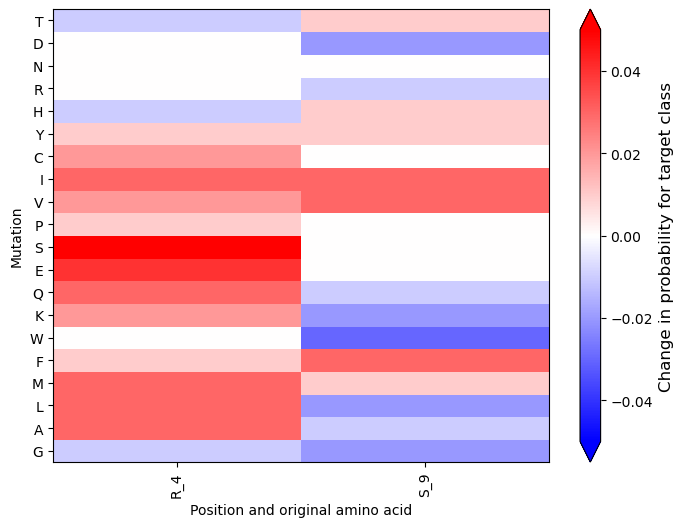

In [22]:
plot_optimization(mutated_scores, initial_score, plot_inplace=True, dpi=100)

Finally, the function `top_mutations` can be used to show the mutations that could improve the localization of the protein at the target location. It takes as arguments the results from `optimize_sequence` and the argument `top_results` expects an integer with the number of `n` best mutations to show to increase the localization. If `top_results` is larger than the number of mutations that increase the probability then only those mutations increasing the probability are returned.

In this example, the top 10 mutations that could improve the probability are returned. The top mutation (R4S) increases the probability of being of the cytoplasm class by 0.05, up to 0.77 from the initial 0.72.

In [23]:
top_mutations(mutated_scores, initial_score, top_results=10)

,Position,Mutation,Prob_increase,Target_probability
0,R_4,S,0.05,0.77
1,R_4,E,0.04,0.76
2,R_4,A,0.03,0.75
3,R_4,L,0.03,0.75
4,R_4,M,0.03,0.75
5,R_4,Q,0.03,0.75
6,R_4,I,0.03,0.75
7,S_9,F,0.03,0.75
8,S_9,V,0.03,0.75
9,S_9,I,0.03,0.75


## 5. Get unirep representations

Additionally, the module contains many functions that are useful for the main functions. However, this functions may also be useful in other cases. For instance, the functions inside `check_inputs.py` can be useful to convert amino acid sequence inputs to a unified single-letter code and check for incorrect symbols. This functions can be accessed specifying the file name that contains them. For instance:

In [24]:
lmpm.check_inputs.check_input('ArgProLeuTrpArgProMetLeuTrpLeuProArg')

'RPLWRPMLWLPR'

In [25]:
lmpm.check_inputs.check_input('rplwrpmlwlpr')

'RPLWRPMLWLPR'

Similarly, the functions in the `unirep` submodule could be helpful to train other machine learning models based on protein sequences. The `get_UniReps` function in that submodule converts a given protein sequence to 1900 features.

In [26]:
unirep_rep = lmpm.unirep.get_UniReps('RPLWRPMLWLPR')
unirep_rep

array([[ 0.047403  ,  0.00459768, -0.0337927 , ...,  0.0806197 ,
         0.12195722, -0.00391885]])

In [27]:
unirep_rep.shape

(1, 1900)